In [1]:
# Python Standard Libraries for importing data from binary file
import os.path #for accessing the file path
import struct  #for unpacking the binary data

import time    #for calculating time
import math    #for using floor in creating minibatches


#core packages
import numpy as np
import matplotlib.pyplot as plt

#custom module
from dataPrep import load_dataset, load_sample_dataset
from dataPrep import prep_dataset, rand_mini_batches

from finalModelUtils import *
from ffnn import *

np.random.seed(1)
%matplotlib inline

In [2]:
#loading complete dataset
train_x_orig, train_y_orig, dev_x_orig,dev_y_orig,test_x_orig,test_y_orig = load_dataset()

In [3]:
#loading Sample dataset
sample_size = 25
train_x_sample, train_y_sample, dev_x_sample, dev_y_sample, test_x_sample, test_y_sample = load_sample_dataset(sample_size)

print("Sample Size : %d%%\n"%(sample_size))
print("Data\t\t\t","Complete Dataset\t","Sample Dataset\t")
print("================================================================")
print("Training Set Images:\t"+ str(train_x_orig.shape)+"\t\t"+ str(train_x_sample.shape))
print("Training Set Labels:\t"+ str(train_y_orig.shape)+"\t\t"+ str(train_y_sample.shape))
print("Training Set Images:\t"+ str(dev_x_orig.shape)+"\t\t"+ str(dev_x_sample.shape))
print("Training Set Labels:\t"+ str(dev_y_orig.shape)+"\t\t"+ str(dev_y_sample.shape))
print("Test Set Images:\t"+str(test_x_orig.shape)+"\t\t"+ str(test_x_sample.shape))
print("Test Set Labels:\t"+str(test_y_orig.shape)+"\t\t"+ str(test_y_sample.shape))
print("================================================================")


Sample Size : 25%

Data			 Complete Dataset	 Sample Dataset	
Training Set Images:	(60000, 28, 28)		(15000, 28, 28)
Training Set Labels:	(60000, 1)		(15000, 1)
Training Set Images:	(5000, 28, 28)		(1250, 28, 28)
Training Set Labels:	(5000, 1)		(1250, 1)
Test Set Images:	(5000, 28, 28)		(1250, 28, 28)
Test Set Labels:	(5000, 1)		(1250, 1)


In [4]:
# Preparing the Dataset (Flattening and Normalizing)
train_x_norm,train_y_encoded, dev_x_norm,dev_y_encoded, test_x_norm, test_y_encoded = prep_dataset(train_x_sample, train_y_sample, dev_x_sample, dev_y_sample, test_x_sample, test_y_sample)
print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_sample.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_sample.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_sample.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_sample.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_sample.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_sample.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(15000, 28, 28)		(784, 15000)
Training Set Labels:	(15000, 1)		(10, 15000)
Dev Set Images:		(1250, 28, 28)		(784, 1250)
Dev Set Labels:		(1250, 1)		(10, 1250)
Test Set Images:	(1250, 28, 28)		(784, 1250)
Test Set Labels:	(1250, 1)		(10, 1250)


## Model Implementation

In [5]:
layers_dim = init_layers(train_x_norm, train_y_encoded, hidden_layers = [800,300])

In [ ]:
hyperParams = init_hyperParams(alpha = 0.0001, num_epoch = 5, mini_batch_size = 512,lambd = 0.7,keep_probs = [0.9,0.8,])

In [ ]:
parameters = train(train_x_norm, train_y_encoded,dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = 'l2') 

## Grid Search

In [6]:
lr = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
mbz = [128, 256, 512, 1024, 2048, 4096]

In [11]:
def grid_search(mbz,lr, metric = "test"):
    
    score = np.zeros((len(mbz),len(lr)))
    toc = time.time()
    
    for ind1,i in enumerate(mbz):
        print("\nMinibatch Size: %d"%(i))
        print("==========================================================================================================")
        
        for ind2,j in enumerate(lr):
            print("\nLearning Rate: %.4f"%(j))
            print("-------------------------------")
            hyperParams = init_hyperParams(alpha = j, num_epoch = 10, mini_batch_size = i)
            parameters = train(train_x_norm, train_y_encoded,dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam', visualize = False) 
            if metric == "test": 
                _,test_acc,_ = predict(test_x_norm, test_y_encoded,parameters)
                score[ind1,ind2] = test_acc
                
            elif metric == "val":
                prediction_dev,dev_acc, _ = predict(dev_x_norm, dev_y_encoded,parameters)
                score[ind1,ind2] = dev_acc
                
            else:
                raise ValueError("Metric must be 'val' or 'test'")

        print("==========================================================================================================")
        
    
    
    tic = time.time() # for calculating entire search time
    hrs, mins, secs , ms = convert_time((tic - toc)*1000)
    
    print("\n\n*************************** Total Training Time = %dhr %dmins %dsecs %.2fms ***************************"%(hrs, mins, secs, ms))
    
    return score

In [12]:
score = grid_search(mbz,lr, metric = "val")
print(score.shape)


Minibatch Size: 128

Learning Rate: 0.0500
-------------------------------

Epoch: 1/10
15000/15000 [==========> 100%] - 45.96s | loss: 0.3966 | acc: 0.9013 | Val loss: 0.4213 | Val acc: 0.9032 
Epoch: 2/10
15000/15000 [==========> 100%] - 46.66s | loss: 0.2862 | acc: 0.9200 | Val loss: 0.3290 | Val acc: 0.9208 
Epoch: 3/10
15000/15000 [==========> 100%] - 46.51s | loss: 0.2747 | acc: 0.9269 | Val loss: 0.3315 | Val acc: 0.9168 
Epoch: 4/10
15000/15000 [==========> 100%] - 47.63s | loss: 0.3228 | acc: 0.9119 | Val loss: 0.4167 | Val acc: 0.9120 
Epoch: 5/10
15000/15000 [==========> 100%] - 46.21s | loss: 0.2789 | acc: 0.9346 | Val loss: 0.3727 | Val acc: 0.9272 
Epoch: 6/10
15000/15000 [==========> 100%] - 46.09s | loss: 0.2288 | acc: 0.9425 | Val loss: 0.3254 | Val acc: 0.9344 
Epoch: 7/10
15000/15000 [==========> 100%] - 46.55s | loss: 0.2602 | acc: 0.9328 | Val loss: 0.3583 | Val acc: 0.9240 
Epoch: 8/10
15000/15000 [==========> 100%] - 46.08s | loss: 0.2628 | acc: 0.9329 | Val los

15000/15000 [==========> 100%] - 23.98s | loss: 0.3390 | acc: 0.9105 | Val loss: 0.3424 | Val acc: 0.9160 
Epoch: 2/10
15000/15000 [==========> 100%] - 24.11s | loss: 0.2724 | acc: 0.9245 | Val loss: 0.3303 | Val acc: 0.9152 
Epoch: 3/10
15000/15000 [==========> 100%] - 25.21s | loss: 0.2435 | acc: 0.9308 | Val loss: 0.2458 | Val acc: 0.9344 
Epoch: 4/10
15000/15000 [==========> 100%] - 23.60s | loss: 0.1796 | acc: 0.9479 | Val loss: 0.2395 | Val acc: 0.9384 
Epoch: 5/10
15000/15000 [==========> 100%] - 23.73s | loss: 0.2167 | acc: 0.9374 | Val loss: 0.3525 | Val acc: 0.9272 
Epoch: 6/10
15000/15000 [==========> 100%] - 23.58s | loss: 0.1895 | acc: 0.9480 | Val loss: 0.3721 | Val acc: 0.9328 
Epoch: 7/10
15000/15000 [==========> 100%] - 23.63s | loss: 0.1623 | acc: 0.9541 | Val loss: 0.2679 | Val acc: 0.9416 
Epoch: 8/10
15000/15000 [==========> 100%] - 23.60s | loss: 0.1474 | acc: 0.9543 | Val loss: 0.2780 | Val acc: 0.9280 
Epoch: 9/10
15000/15000 [==========> 100%] - 24.06s | loss: 

15000/15000 [==========> 100%] - 12.89s | loss: 0.4571 | acc: 0.8579 | Val loss: 0.4884 | Val acc: 0.8552 
Epoch: 2/10
15000/15000 [==========> 100%] - 12.65s | loss: 0.2921 | acc: 0.9109 | Val loss: 0.3151 | Val acc: 0.9136 
Epoch: 3/10
15000/15000 [==========> 100%] - 12.58s | loss: 0.2214 | acc: 0.9331 | Val loss: 0.2892 | Val acc: 0.9200 
Epoch: 4/10
15000/15000 [==========> 100%] - 12.48s | loss: 0.2201 | acc: 0.9317 | Val loss: 0.2832 | Val acc: 0.9208 
Epoch: 5/10
15000/15000 [==========> 100%] - 12.51s | loss: 0.1942 | acc: 0.9417 | Val loss: 0.2702 | Val acc: 0.9232 
Epoch: 6/10
15000/15000 [==========> 100%] - 12.46s | loss: 0.1616 | acc: 0.9505 | Val loss: 0.2543 | Val acc: 0.9360 
Epoch: 7/10
15000/15000 [==========> 100%] - 12.48s | loss: 0.1630 | acc: 0.9464 | Val loss: 0.2606 | Val acc: 0.9360 
Epoch: 8/10
15000/15000 [==========> 100%] - 12.44s | loss: 0.1383 | acc: 0.9548 | Val loss: 0.2624 | Val acc: 0.9360 
Epoch: 9/10
15000/15000 [==========> 100%] - 12.49s | loss: 

15000/15000 [==========> 100%] - 6.77s | loss: 1.0080 | acc: 0.6480 | Val loss: 1.0267 | Val acc: 0.6456 
Epoch: 2/10
15000/15000 [==========> 100%] - 6.82s | loss: 0.4765 | acc: 0.8619 | Val loss: 0.4890 | Val acc: 0.8776 
Epoch: 3/10
15000/15000 [==========> 100%] - 6.78s | loss: 0.3108 | acc: 0.9100 | Val loss: 0.3236 | Val acc: 0.9104 
Epoch: 4/10
15000/15000 [==========> 100%] - 6.71s | loss: 0.2214 | acc: 0.9347 | Val loss: 0.2678 | Val acc: 0.9224 
Epoch: 5/10
15000/15000 [==========> 100%] - 6.71s | loss: 0.1828 | acc: 0.9460 | Val loss: 0.2370 | Val acc: 0.9376 
Epoch: 6/10
15000/15000 [==========> 100%] - 6.68s | loss: 0.1508 | acc: 0.9551 | Val loss: 0.2499 | Val acc: 0.9400 
Epoch: 7/10
15000/15000 [==========> 100%] - 6.72s | loss: 0.1337 | acc: 0.9599 | Val loss: 0.2393 | Val acc: 0.9464 
Epoch: 8/10
15000/15000 [==========> 100%] - 7.19s | loss: 0.1282 | acc: 0.9622 | Val loss: 0.2313 | Val acc: 0.9512 
Epoch: 9/10
15000/15000 [==========> 100%] - 7.53s | loss: 0.1285 | 

15000/15000 [==========> 100%] - 4.31s | loss: 1.6213 | acc: 0.4727 | Val loss: 1.6147 | Val acc: 0.4792 
Epoch: 2/10
15000/15000 [==========> 100%] - 4.18s | loss: 0.9536 | acc: 0.7177 | Val loss: 0.9688 | Val acc: 0.7440 
Epoch: 3/10
15000/15000 [==========> 100%] - 4.09s | loss: 0.6947 | acc: 0.7808 | Val loss: 0.6664 | Val acc: 0.8048 
Epoch: 4/10
15000/15000 [==========> 100%] - 3.99s | loss: 0.5176 | acc: 0.8309 | Val loss: 0.5170 | Val acc: 0.8400 
Epoch: 5/10
15000/15000 [==========> 100%] - 4.01s | loss: 0.4248 | acc: 0.8805 | Val loss: 0.4263 | Val acc: 0.8872 
Epoch: 6/10
15000/15000 [==========> 100%] - 4.04s | loss: 0.3620 | acc: 0.8950 | Val loss: 0.3823 | Val acc: 0.8888 
Epoch: 7/10
15000/15000 [==========> 100%] - 4.19s | loss: 0.3140 | acc: 0.9067 | Val loss: 0.3947 | Val acc: 0.8896 
Epoch: 8/10
15000/15000 [==========> 100%] - 4.15s | loss: 0.2749 | acc: 0.9177 | Val loss: 0.3344 | Val acc: 0.9096 
Epoch: 9/10
15000/15000 [==========> 100%] - 4.19s | loss: 0.2882 | 

15000/15000 [==========> 100%] - 2.53s | loss: 9.1629 | acc: 0.1867 | Val loss: 9.4044 | Val acc: 0.1984  
Epoch: 2/10
15000/15000 [==========> 100%] - 2.62s | loss: 1.5221 | acc: 0.4697 | Val loss: 1.5068 | Val acc: 0.4952 
Epoch: 3/10
15000/15000 [==========> 100%] - 2.61s | loss: 1.1866 | acc: 0.6017 | Val loss: 1.1949 | Val acc: 0.6096 
Epoch: 4/10
15000/15000 [==========> 100%] - 2.47s | loss: 1.0102 | acc: 0.6279 | Val loss: 0.9866 | Val acc: 0.6312 
Epoch: 5/10
15000/15000 [==========> 100%] - 2.43s | loss: 0.8479 | acc: 0.6791 | Val loss: 0.8334 | Val acc: 0.6896 
Epoch: 6/10
15000/15000 [==========> 100%] - 2.44s | loss: 0.7213 | acc: 0.7537 | Val loss: 0.7162 | Val acc: 0.7584 
Epoch: 7/10
15000/15000 [==========> 100%] - 2.44s | loss: 0.5999 | acc: 0.8189 | Val loss: 0.5895 | Val acc: 0.8120 
Epoch: 8/10
15000/15000 [==========> 100%] - 2.69s | loss: 0.5263 | acc: 0.8388 | Val loss: 0.4998 | Val acc: 0.8360 
Epoch: 9/10
15000/15000 [==========> 100%] - 2.49s | loss: 0.4492 |

In [13]:
print(score)
print(np.where(score == np.max(score)))

[[0.9224 0.9656 0.9704 0.976  0.9712 0.9648]
 [0.9368 0.9656 0.9624 0.9744 0.9696 0.9616]
 [0.932  0.9656 0.9648 0.9688 0.968  0.9504]
 [0.94   0.9688 0.9672 0.968  0.9648 0.9352]
 [0.9144 0.968  0.964  0.96   0.9616 0.9104]
 [0.8912 0.9568 0.9632 0.952  0.9448 0.86  ]]
(array([0]), array([3]))


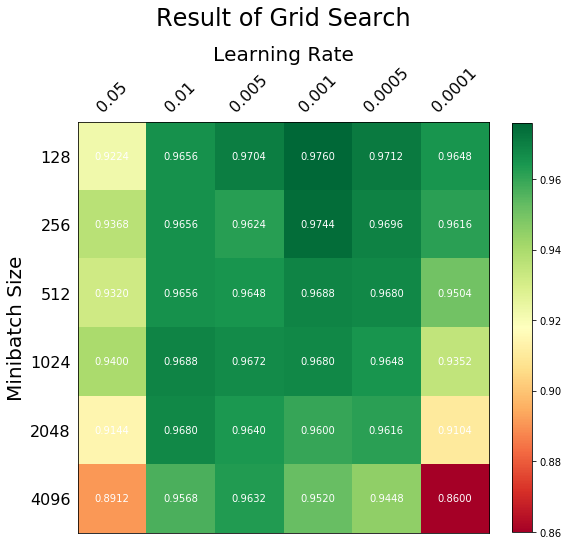

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
im = plt.imshow(score,cmap="RdYlGn") #RdYlGn, PiYG, Accent,Blues,viridis, YlGnBu
fig.colorbar(im,ax=ax,fraction=0.045)

m = len(lr)
n = len(mbz)
    
ax.set_title("Result of Grid Search",fontsize=24,pad = 20)
ax.set_xticks(range(0,m))
ax.set_yticks(range(0,n))
ax.set_xlabel("Learning Rate", fontsize = 20)
ax.set_ylabel("Minibatch Size", fontsize = 20)

ax.set_xticklabels(lr,fontsize=16,rotation=45)
ax.set_yticklabels(mbz,fontsize=16)

#setting horizontal axes labeling to top.
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')


# Turn off all the ticks
ax.tick_params(top=False,left=False)


thres = 0.8

for i in range(n):
    for j in range(m):
        ax.text(j, i, "%.4f"%(score[i, j]),
                       ha="center", va="center", color="w" if score[i,j] > thres else "black")


fig.tight_layout()
plt.show()


## Random Search

In [ ]:
cm_train = confusion_matrix(train_y_sample,prediction_train)

cm_dev = confusion_matrix(dev_y_sample,prediction_dev)

cm_test = confusion_matrix(test_y_sample,prediction_test)

In [ ]:
metrics, macro_metrics, acc = model_metrics(cm_train)

In [ ]:
save_model(file_name = "hyperParameters", parameters = hyper_params)

In [ ]:
loaded_hyper_params = load_model(file_name = "final_model_adam_dropout")

In [ ]:
for key,value in loaded_hyper_params.items():
    print(key + ": " + str(value))